## Building an MLP

Today we will build an MLP to detect the next character in the sequence. 

Based on the paper: A Neural Probabilistic Language Model

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
with open("names.txt", "r") as file:
    words = file.read().splitlines()

words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [7]:
len(words)

32033

In [9]:
# build a vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [135]:
# compile the dataset

block_size = 3  # context length: how many characters do we take to predict the next one

X, Y = [], []
for w in words:
    
    # print(w)
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[i] for i in context), "---->", itos[ix])
        context = context[1:] + [ix]    # crop and append

# basically we have a rolling window for context
X = torch.tensor(X)
Y = torch.tensor(Y)

In [136]:
X.shape, Y.shape, X.dtype, Y.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [38]:
C = torch.randn((27, 2))    # lookup table
C[5]

tensor([ 0.8919, -0.0543])

In [39]:
F.one_hot(torch.tensor(5), num_classes=27).float().shape, C.shape
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.8919, -0.0543])

In [52]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [54]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [56]:
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [69]:
torch.cat(torch.unbind(emb, dim=1), dim=1).shape
# unbind takes slices from every single dim and returns htem as a tuple

torch.Size([32, 6])

In [76]:
a = torch.arange(18)
a.view(3, 3, 2) # this operation is extremely efficient in pytorch
# a.storage()

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [89]:
(emb.view(32, 6) == torch.cat(torch.unbind(emb, dim=1), dim=1)).all()

tensor(True)

In [92]:
# h = emb.view(emb.shape[0], 6) @ W1 + b1
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)   # -1 and pytorch infers what that dim should be
h.shape

# contatenation if less inefficient as it creates new memory as it needs to do so

torch.Size([32, 100])

In [95]:
(emb.view(-1, 6) @ W1).shape, b1.shape
# 32, 100
#   , 100
# the broadcasting here is correct; always good to do a sanity check to not shoot yourself in the foot by accident

(torch.Size([32, 100]), torch.Size([100]))

In [96]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [99]:
logits = h @ W2 +b2
logits.shape

torch.Size([32, 27])

In [100]:
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

In [108]:
nll = -probs[torch.arange(32), Y].log().mean()
nll

tensor(18.0700)

In [109]:
# ----------------------- putting everything together to be readable ----------------------------- #

In [137]:
# dataset
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [154]:
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

Total number of parameters: 3481


In [120]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 +b2
# counts = logits.exp()
# probs = counts / counts.sum(dim=1, keepdim=True)
# nll = -probs[torch.arange(32), Y].log().mean()    # loss
# nll   # this is all inefficient as pytorch would never make these new tensors in memory to do these calculations
# NOTE: pytorch will have fused clustered kernels that efficently evaluate these operations
# plus the backward pass will be more simple and efficient
loss = F.cross_entropy(logits, target=Y)    # it can be more numerically well behaved (numerically stable)
loss

tensor(17.7697)

In [125]:
logits = torch.tensor([-100, -2, 0, 100]) # pytorch internally calculates the max number and subtract the logits from it because an offset doesnt afect the exp()
counts = logits.exp()
probs = counts / counts.sum()
probs

tensor([0., 0., 0., nan])

In [126]:
counts  # we run out of range and get a nan; we cannot pass very large logits

tensor([3.7835e-44, 1.3534e-01, 1.0000e+00,        inf])

In [231]:
with open("names.txt", "r") as file:
    words = file.read().splitlines()

In [232]:
def build_dataset(words):
    block_size = 3  # context length: how many characters do we take to predict the next one

    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]    # crop and append

    # basically we have a rolling window for context
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [244]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [245]:
for p in parameters:
    p.requires_grad = True

In [246]:
# we can assume that the best gradient value is between 0.001 and 1
lr_exponent = torch.linspace(-3, 0, steps=1000)
lrs = 10**lr_exponent

In [259]:
lr = 0.01
lri = []
lossi = []
stepi = []

for i in range(30000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(
        logits, target=Ytr[ix]
    )  # it can be more numerically well behaved (numerically stable)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    # parameter update
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr_exponent[i])
    lossi.append(loss.item())
    stepi.append(i)

# print(loss.item())


# because we are dealing with minibatches, the quality of our gradient is lower as the direction of the gradient is not as reliable. it is NOT the actual gradient direction but it is GOOD ENOUGH
# better to have an approximate gradient direction and have more steps

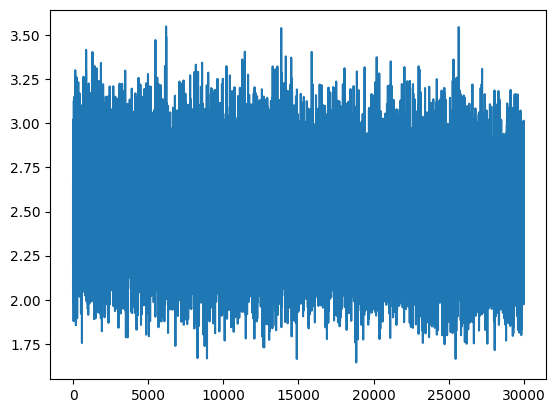

In [251]:
plt.plot(stepi, lossi);

We can see that there is a bit of thickness in the later number of stps as the minibatches CREATE NOISE!

One more thing that might be possible is having too small of a batch size and introducing way too much noise in the training. we want to increase the batch size to not have the gradient do to much trashing. 

A small loss differnce is acheived, lowering the lr by a factor of 2 to 0.05. 


We are not seeing a too big of a difference in loss even though we increased the model hiddden layer size. The bootleneck of the network could be that we are cramming too much characters into 2 dimensions embeddings. the neural net cannot use that space effectively.



In [254]:
print(loss.item())

2.3277974128723145


In [260]:
# evaluation so to speak. To get the loss on the entire dataset not just the minibatch
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, target=Ytr)    # it can be more numerically well behaved (numerically stable)
loss

tensor(2.2384, grad_fn=<NllLossBackward0>)

In [261]:
# evaluation so to speak. To get the loss on the entire dataset not just the minibatch
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, target=Ydev)    # it can be more numerically well behaved (numerically stable)
loss

tensor(2.2461, grad_fn=<NllLossBackward0>)

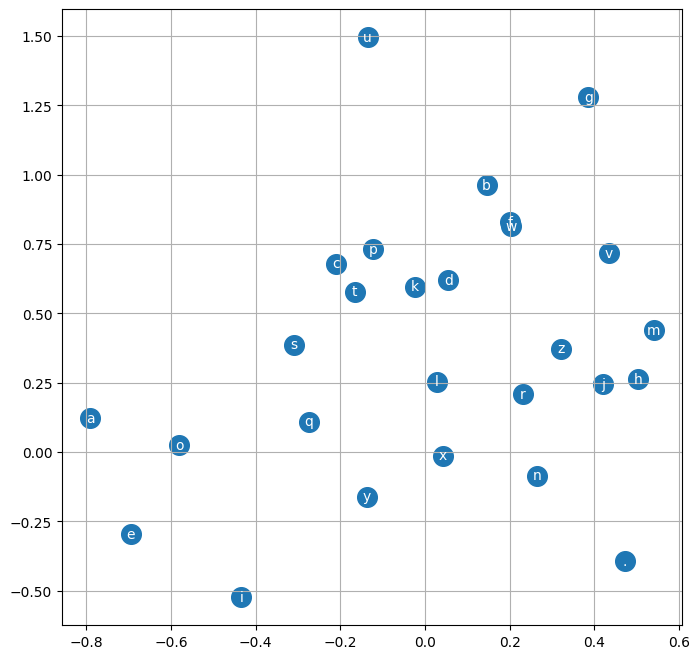

In [267]:
# visualize the embeddings while they are still 2 dimensional trained by the neural net on these characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor");

We can see that the neural net has clustered the vowels together. Which makes sense. 'g' and '.' are treated separately. There is a little bit of strcuture after training. 

Train loss: 2.4264  Val loss: 2.4252

We are underfitting as the train and val losses are roughly equal. That means we need a more complex network, i.e. we need to scale up. 

We will bump the number of neurons in the hidden layer from 100 to 300. 



The first run with lr=0.1 loss is 2.4858.

The second run it is 2.4255. 

The third run it is 2.45

The fourth is 2.3792 which is better than the bigram model as it had a loss of 2.45.

Now we can do one learning rate decay to 0.01 and run the training again. 

Now, with a lr of 0.01 we have a loss of 2.3130, then 2.3106, finally 2.3107.

BUT we are achieving these losses on just the TRAIN dataset. 

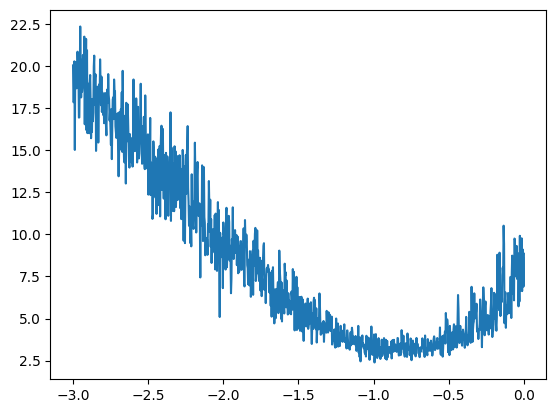

In [189]:
plt.plot(lri, lossi);

We can see that the best learning rate might be around -1.0. And since we are looking at exponents, 10**-1 is 0.1 which is a good starting learning rate for this purpose. 

In [131]:
logits.max(dim=1)

torch.return_types.max(
values=tensor([13.4075, 17.9508, 20.6713, 20.7180, 16.8477, 13.4075, 16.1055, 14.2639,
        16.0061, 18.4900, 16.0633, 21.0431, 13.4075, 17.2463, 17.2555, 20.1906,
        13.4075, 16.6964, 15.2456, 17.1910, 18.6856, 16.0948, 10.9866, 10.7859,
        15.5817, 13.4075, 16.2812, 17.0793, 12.8177, 16.2843, 19.2147, 16.1754],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [133]:
Y
# NOTE: we cannot overfit on these data as we have several examples where we have a sample ... but different target values

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [ ]:
# NOTE
# training split, dev/validation split, test split
# 80%, 10%, 10%

# val split is used for hyperparameter training/optimization sucha as learning rate, hidden layer size, regularization strength etc.

You need to run the evaluation very few times on the test dataset as well as you will eventually overfit on it as well as you will try to get better results from it as you experiment on your model. 